<a href="https://colab.research.google.com/github/Tonge-Shim/pytorchstudy/blob/main/chap7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Telling birds from airplanes:
#Learning from images
> building a feed-forward neural network

> Loading data using `Datasets` and `DataLoaders`

> Understanding classification loss

#CIFAR-10
> consists of 60000 tiny 32*32 color(RGB) images, labeled with an interger corresponding to 1 of 10 classes.

> use torchvision module to automatically download the dataset and load it as a collection of PyTorch tensors.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
from PIL import Image

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [2]:
import torch
from torchvision import datasets
data_path = '/content/sample_data'#location where the data will be downloaded
cifar10 = datasets.CIFAR10(data_path, train=True, download = True)
cifar10_val = datasets.CIFAR10(data_path, train = False, download = True)


Extracting /content/sample_data/cifar-10-python.tar.gz to /content/sample_data
Files already downloaded and verified


In [3]:
type(cifar10).__mro__#method-resolution order of cifar 10

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

`__len__, __getitem__`

In [4]:
print(len(cifar10))
print(len(cifar10_val))

50000
10000


In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F1934B34CD0>,
 1,
 'automobile')

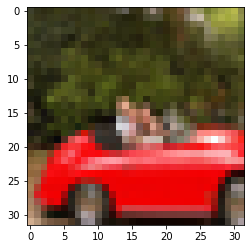

In [6]:
plt.imshow(img)
plt.show()

#PIL -> PyTorch tensor
> `torchvision.transforms`

> `ToTensor`: NumPy arrays and PIL images to tensors

In [7]:
from torchvision import transforms
dir(transforms)

['AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [8]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [43]:
#accessing an element of the dataset will return a tensor, rather than a PIL image
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download = False, transform = transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download = False, transform = transforms.ToTensor())
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [10]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

the values in the original PIL image ranged from 0 to 255(8 bits per channel), the ToTensor transfrom turns the data into a 32-bit floating-point per channel, scaling the values down from 0.0 to 1.0.

In [11]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

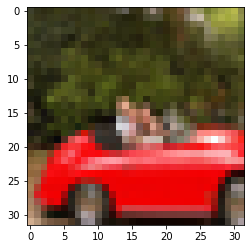

In [12]:
plt.imshow(img_t.permute(1,2,0))#changes the order of the axes from c*h*w to h*w*c reason: to match what Matplotlib expects.
plt.show()

#`transforms.Normalize`

In [13]:
imgs = torch.stack([img_t for img_t,_ in tensor_cifar10], dim = 3)
imgs.shape

torch.Size([3, 32, 32, 50000])

#view(3, -1)

> keeps the 3 channels and merges all the remaining dimensions into one, figuring out the appropriate size. our 3x32x32 image is transformed into a 3x1024 vector, and then the mean is taken over the 1024 elements of each channel.


In [14]:
imgs.view(3, -1).mean(dim = 1)

tensor([0.4914, 0.4822, 0.4465])

In [15]:
imgs.view(3, -1).std(dim = 1)

tensor([0.2470, 0.2435, 0.2616])

In [16]:
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [17]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train = True, download = False, 
    transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                                    
    ])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


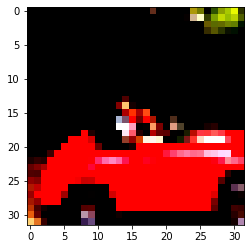

In [18]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [44]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in tensor_cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [20]:
import torch.nn as nn

In [21]:
n_out = 2

model = nn.Sequential(
    nn.Linear(
        3072, #input layer
        512, #hidden layer size
    ),
    nn.Tanh(),
    nn.Linear(
        512,
        n_out
    )
)

In [22]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [24]:
#text
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [25]:
softmax(x).sum()

tensor(1.)

In [26]:
softmax = nn.Softmax(dim = 1)#specify dimension
x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [27]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim = 1)
)

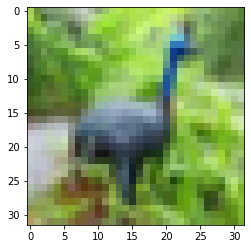

In [28]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [29]:
img_batch = img.view(-1).unsqueeze(0)
out = model(img_batch)
out

tensor([[0.4091, 0.5909]], grad_fn=<SoftmaxBackward>)

In [30]:
_, index = torch.max(out, dim = 1)
index

tensor([1])

In [32]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

In [33]:
loss = nn.NLLLoss()
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))


tensor(0.7217, grad_fn=<NllLossBackward>)

#training the classifier

In [ ]:
import torch
import torch.nn as nn

In [34]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)# DataLoader can be iterated over, so we can use it directly in the inner loop of our new training code

In [ ]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)
learning_rate = 1e-2

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

loss_fn = nn.NLLLoss()
n_epochs = 100
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: %d, Loss: %f" %(epoch, float(loss)))
     

In [53]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim = 1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: ", (correct/total))


Accuracy:  0.8375
